In [1]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import os
import json
import re

# nltk
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stoplist= stopwords.words('english')
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer= WordNetLemmatizer()
from nltk import SnowballStemmer
from nltk.tokenize import word_tokenize
nltk.download('punkt')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

from unidecode import unidecode

from wordcloud import WordCloud

import warnings
warnings.filterwarnings('ignore')

# Enable logging
import logging
logging.basicConfig(level= logging.INFO)

PROJECT_PATH = os.environ.get("PROJECT_PATH")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ryandelopez/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/ryandelopez/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
data_path = PROJECT_PATH + "relabeled_training_data.json"

with open(data_path, "r") as file:
    data = json.load(file)

# convert data to pandas dataframe
df = pd.DataFrame(data)

# drop columns
# df.drop(columns= ["retweet_count", "user_id", "user_followers", "created_date", "created_time", "embedding"], inplace= True)

df.head()

,text,entity,entity_classification,risk_sentiment
0,Fifth Third Bancorp 4th-Quarter Net Rose 27% o...,fifth_third,Correct Entity,Not Indicative of a Bank Run
1,#hiring: finance manager - Fifth Third Bank - ...,fifth_third,Correct Entity,Not Indicative of a Bank Run
2,RT @MudHens: Super cool Fifth Third Field post...,fifth_third,Incorrect Entity,Not Indicative of a Bank Run
3,I just ousted Larry W. as the mayor of Fifth T...,fifth_third,Correct Entity,Not Indicative of a Bank Run
4,Lynette in Columbus Ohio endorses Fifth Third ...,fifth_third,Correct Entity,Not Indicative of a Bank Run


In [3]:
corpus = df['text'].tolist()

# Define the bank names and their alternative names
banks = [
    ("Capital One Financial Corporation", ["Capital One Bank", "Capital One"]),
    ("Fifth Third Bancorp", ["Fifth Third Bank"]),
    ("U.S. Bancorp", ["U.S. Bank", "U.S. Bancorp Bank"]),
    ("Truist Financial Corporation", ["Truist", "SunTrust", "BB&T", "SunTrust BB&T"]),
    ("Bank of New York Mellon Corporation", ["BNY Mellon", "The Bank of New York Mellon", "BNY Mellon Bank"]),
]

# Function to create a regex pattern for each bank
def create_bank_pattern(main_name, alternatives):
    # Escape special regex characters in bank names
    escaped_names = [re.escape(name) for name in alternatives]
    # Include the main bank name in the pattern
    escaped_main_name = re.escape(main_name)
    # Combine the main bank name and its alternatives into one pattern
    pattern = r'\b(?:' + '|'.join([escaped_main_name] + escaped_names) + r')\b'
    return pattern

# removes a list of words (ie. stopwords) from a tokenized list.
def removeWords(listOfTokens, listOfWords):
    return [token for token in listOfTokens if token not in listOfWords]

# applies stemming to a list of tokenized words
def applyStemming(listOfTokens, stemmer):
    return [stemmer.stem(token) for token in listOfTokens]

# removes any words composed of less than 2 or more than 21 letters
def twoLetters(listOfTokens):
    twoLetterWord = []
    for token in listOfTokens:
        if len(token) <= 2 or len(token) >= 21:
            twoLetterWord.append(token)
    return twoLetterWord

def processCorpus(corpus, language):   
    stopwords = nltk.corpus.stopwords.words(language)
    param_stemmer = SnowballStemmer(language)
    
    for document in corpus:
        index = corpus.index(document)
        corpus[index] = corpus[index].replace(u'\ufffd', '8')   # Replaces the ASCII '�' symbol with '8'
        corpus[index] = corpus[index].replace(',', '')          # Removes commas
        corpus[index] = corpus[index].rstrip('\n')              # Removes line breaks
        corpus[index] = corpus[index].casefold()                # Makes all letters lowercase
        
        corpus[index] = re.sub('\W_',' ', corpus[index])        # removes specials characters and leaves only words
        corpus[index] = re.sub("\S*\d\S*"," ", corpus[index])   # removes numbers and words concatenated with numbers IE h4ck3r. Removes road names such as BR-381.
        corpus[index] = re.sub("\S*@\S*\s?"," ", corpus[index]) # removes emails and mentions (words with @)
        corpus[index] = re.sub(r'http\S+', '', corpus[index])   # removes URLs with http
        corpus[index] = re.sub(r'www\S+', '', corpus[index])    # removes URLs with www
        for main_name, alternatives in banks:
            pattern = create_bank_pattern(main_name, alternatives)
            corpus[index] = re.sub(pattern, 'bank', corpus[index], flags=re.IGNORECASE)    # (optional) change bank names to "bank"

        listOfTokens = word_tokenize(corpus[index])
        twoLetterWord = twoLetters(listOfTokens)

        listOfTokens = removeWords(listOfTokens, stopwords)
        listOfTokens = removeWords(listOfTokens, twoLetterWord)
        
        listOfTokens = applyStemming(listOfTokens, param_stemmer)

        corpus[index]   = " ".join(listOfTokens)
        corpus[index] = unidecode(corpus[index])

    return corpus

corpus = processCorpus(corpus, 'english')
print(corpus[0])

fifth third bancorp net rose fewer charge-off fifth third bancorp fitb fourth-quart ...


In [4]:
# Convert the text data into TF-IDF vectors
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)
tf_idf = pd.DataFrame(data = X.toarray(), columns=vectorizer.get_feature_names_out())

final_df = tf_idf

print("{} rows".format(final_df.shape[0]))
final_df.T.nlargest(5, 0)

1025 rows


,0,1,2,3,4,5,6,7,8,9,...,1015,1016,1017,1018,1019,1020,1021,1022,1023,1024
bancorp,0.365134,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
charge,0.323612,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
fewer,0.323612,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
third,0.321029,0.0,0.185849,0.0,0.0,0.325014,0.219809,0.233205,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
fifth,0.318054,0.0,0.184127,0.0,0.0,0.322002,0.217772,0.231044,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
ssd = []

def run_KMeans(max_k, data):
    max_k += 1
    kmeans_results = dict()
    for k in range(2 , max_k):
        kmeans = KMeans(n_clusters = k
                               , init = 'k-means++'
                               , n_init = 10
                               , tol = 0.0001
                               , random_state = 1
                               , algorithm = 'lloyd')
        ssd.append(kmeans.fit(data).inertia_)
        kmeans_results.update( {k : kmeans.fit(data)} )
        
    return kmeans_results

def printAvg(avg_dict):
    for avg in sorted(avg_dict.keys(), reverse=True):
        print("Avg: {}\tK:{}".format(avg.round(4), avg_dict[avg]))
        
def plotSilhouette(df, n_clusters, kmeans_labels, silhouette_avg):
    fig, ax1 = plt.subplots(1)
    fig.set_size_inches(8, 6)
    ax1.set_xlim([-0.2, 1])
    ax1.set_ylim([0, len(df) + (n_clusters + 1) * 10])
    
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--") # The vertical line for average silhouette score of all the values
    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.title(("Silhouette analysis for K = %d" % n_clusters), fontsize=10, fontweight='bold')
    
    y_lower = 10
    sample_silhouette_values = silhouette_samples(df, kmeans_labels) # Compute the silhouette scores for each sample
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[kmeans_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i)) # Label the silhouette plots with their cluster numbers at the middle
        y_lower = y_upper + 10  # Compute the new y_lower for next plot. 10 for the 0 samples
    plt.show()
    
        
def silhouette(kmeans_dict, df, plot=False):
    df = df.to_numpy()
    avg_dict = dict()
    for n_clusters, kmeans in kmeans_dict.items():      
        kmeans_labels = kmeans.predict(df)
        silhouette_avg = silhouette_score(df, kmeans_labels) # Average Score for all Samples
        avg_dict.update( {silhouette_avg : n_clusters} )
    
        if(plot): plotSilhouette(df, n_clusters, kmeans_labels, silhouette_avg)

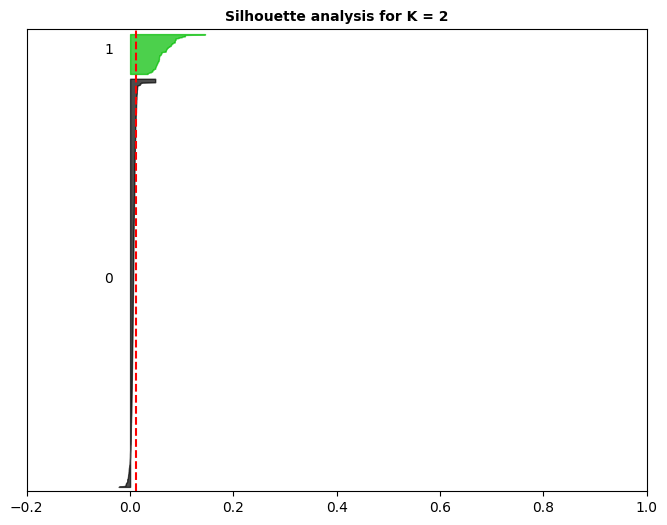

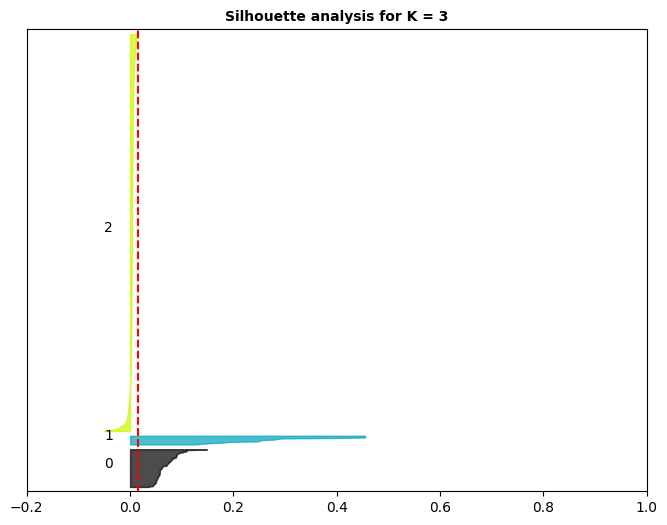

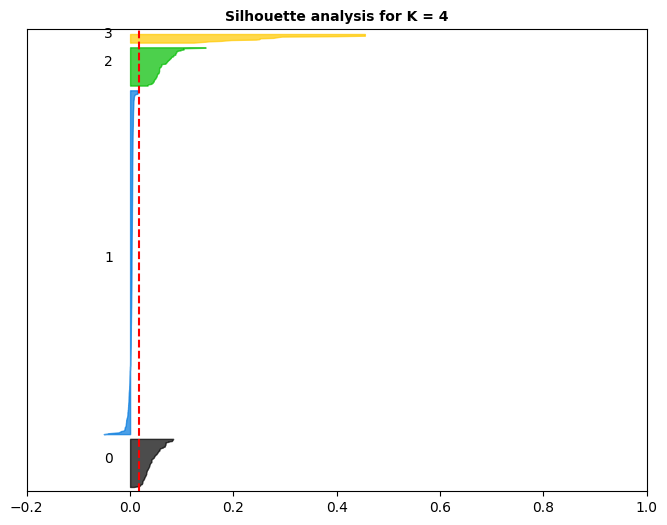

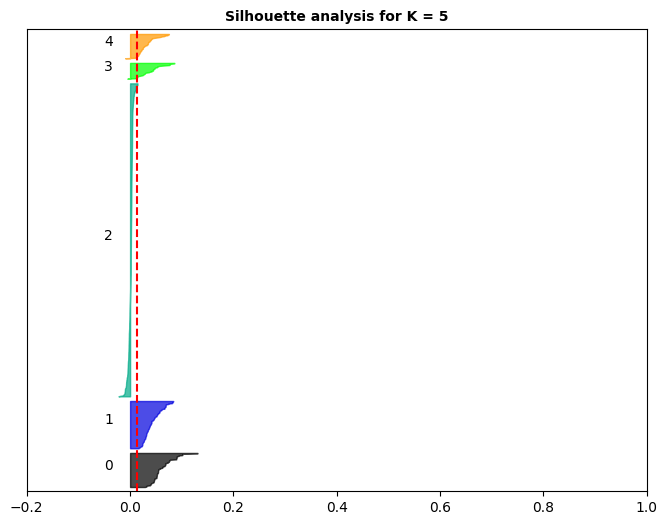

In [6]:
# Run KMeans
k = 5
kmeans_results = run_KMeans(k, final_df)

# Plotting Silhouette Analysis
silhouette(kmeans_results, final_df, plot=True)

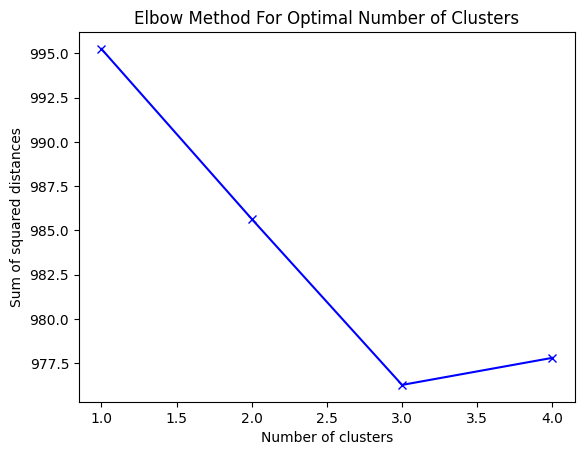

In [7]:
# Plot sum of squared distances / elbow plot
plt.plot(range(1,k), ssd, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal Number of Clusters')
plt.show()

In [8]:
def get_top_features_cluster(tf_idf_array, prediction, n_feats):
    labels = np.unique(prediction)
    dfs = []
    for label in labels:
        id_temp = np.where(prediction==label) # indices for each cluster
        x_means = np.mean(tf_idf_array[id_temp], axis = 0) # returns average score across cluster
        sorted_means = np.argsort(x_means)[::-1][:n_feats] # indices with top 20 scores
        features = vectorizer.get_feature_names_out()
        best_features = [(features[i], x_means[i]) for i in sorted_means]
        df = pd.DataFrame(best_features, columns = ['features', 'score'])
        dfs.append(df)
    return dfs

def plotWords(dfs, n_feats):
    plt.figure(figsize=(8, 4))
    for i in range(0, len(dfs)):
        plt.title(("Most Common Words in Cluster {}".format(i)), fontsize=10, fontweight='bold')
        sns.barplot(x = 'score' , y = 'features', orient = 'h' , data = dfs[i][:n_feats])
        plt.show()

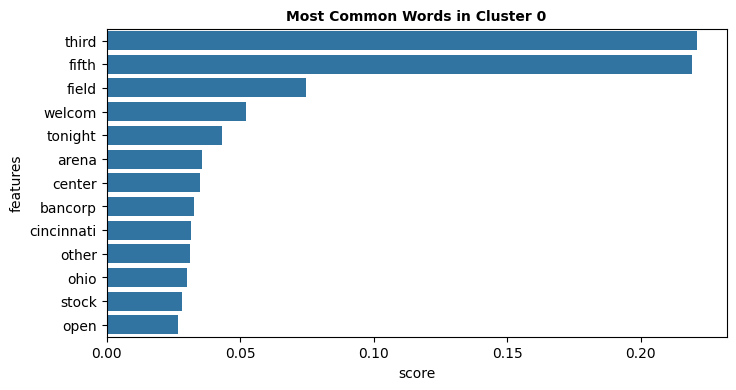

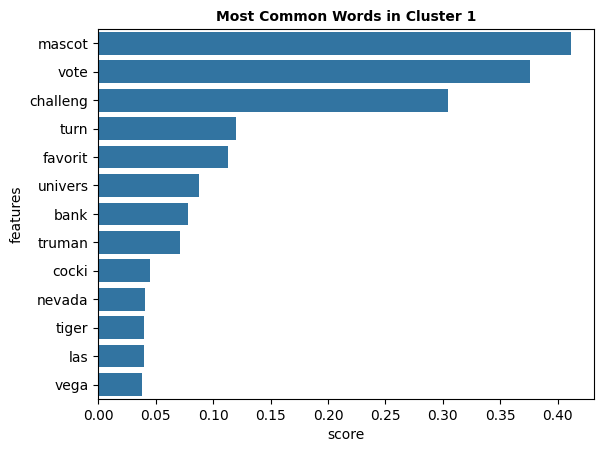

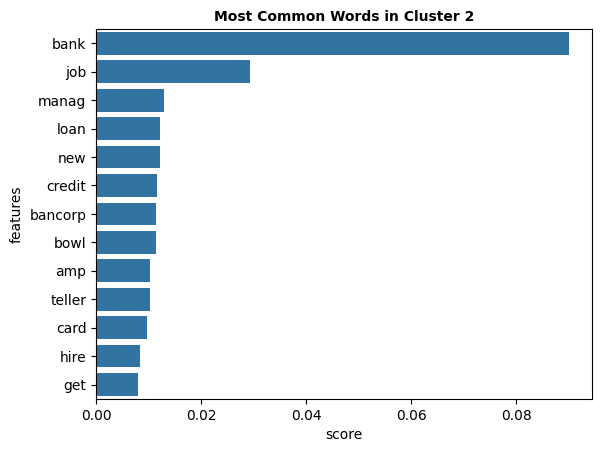

In [9]:
best_result = 3
kmeans = kmeans_results.get(best_result)

final_df_array = final_df.to_numpy()
prediction = kmeans.predict(final_df)
n_feats = 20
dfs = get_top_features_cluster(final_df_array, prediction, n_feats)
plotWords(dfs, 13)

In [10]:
# Transforms a centroids dataframe into a dictionary to be used on a WordCloud.
def centroidsDict(centroids, index):
    a = centroids.T[index].sort_values(ascending = False).reset_index().values
    centroid_dict = dict()

    for i in range(0, len(a)):
        centroid_dict.update( {a[i,0] : a[i,1]} )

    return centroid_dict

def generateWordClouds(centroids):
    wordcloud = WordCloud(max_font_size=100, background_color = 'white')
    for i in range(0, len(centroids)):
        centroid_dict = centroidsDict(centroids, i)        
        wordcloud.generate_from_frequencies(centroid_dict)

        plt.figure()
        plt.title('Cluster {}'.format(i))
        plt.imshow(wordcloud)
        plt.axis("off")
        plt.show()

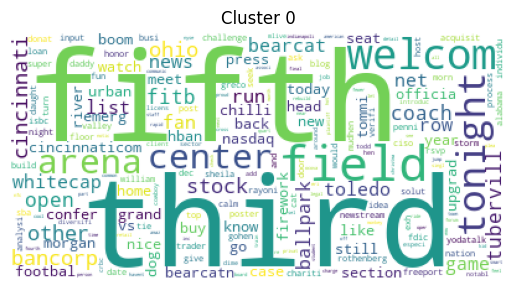

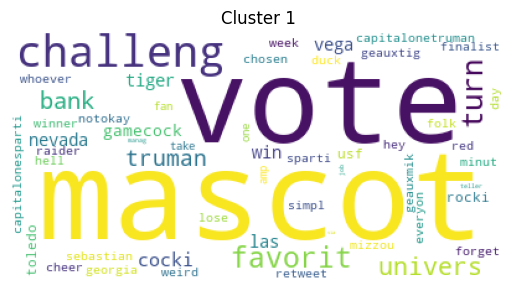

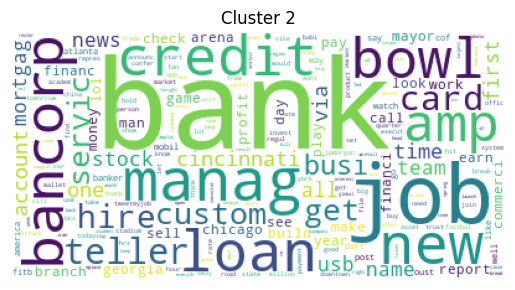

In [11]:
centroids = pd.DataFrame(kmeans.cluster_centers_)
centroids.columns = final_df.columns
generateWordClouds(centroids)

In [12]:
# Assigning the cluster labels to each country
labels = kmeans.labels_ 
df['label'] = labels
df.head()

,text,entity,entity_classification,risk_sentiment,label
0,Fifth Third Bancorp 4th-Quarter Net Rose 27% o...,fifth_third,Correct Entity,Not Indicative of a Bank Run,0
1,#hiring: finance manager - Fifth Third Bank - ...,fifth_third,Correct Entity,Not Indicative of a Bank Run,2
2,RT @MudHens: Super cool Fifth Third Field post...,fifth_third,Incorrect Entity,Not Indicative of a Bank Run,0
3,I just ousted Larry W. as the mayor of Fifth T...,fifth_third,Correct Entity,Not Indicative of a Bank Run,2
4,Lynette in Columbus Ohio endorses Fifth Third ...,fifth_third,Correct Entity,Not Indicative of a Bank Run,2
